# Elliptic Curve Cryptography: a gentle introduction
Этот нотбук создан по материалам специалиста по криптографии [Andrea Corbellini](https://andrea.corbellini.name/about/)
 - Перевод на рус. https://habr.com/ru/post/335906/
 - Оригинал статьи https://andrea.corbellini.name/2015/05/17/elliptic-curve-cryptography-a-gentle-introduction/
 - Полезная книга https://cryptobook.nakov.com/

## Specifically, here are the topics I'll touch:

 1. Elliptic curves over real numbers and the group law (covered in this blog post)
 2. Elliptic curves over finite fields and the discrete logarithm problem
 3. Key pair generation and two ECC algorithms: ECDH and ECDSA
 4. Algorithms for breaking ECC security, and a comparison with RSA

## Elliptic Curves
First of all: what is an elliptic curve? Wolfram MathWorld gives an excellent and complete [definition](http://mathworld.wolfram.com/EllipticCurve.html). But for our aims, an elliptic curve will simply be the <br/> **set of points described by the equation:**

 &emsp;&emsp;&emsp;<img src="https://hsto.org/getpro/habr/formulas/f8a/1d4/e7c/f8a1d4e7c02e3e80a6f789444d105449.svg"></img>
 
 where <img src="https://habrastorage.org/getpro/habr/formulas/3b9/a17/bd3/3b9a17bd316060f393c44653b410fbfb.svg"></img>
 (this is required to exclude [singular curves](https://en.wikipedia.org/wiki/Singularity_(mathematics))). The equation above is what is called Weierstrass normal form for elliptic curves.


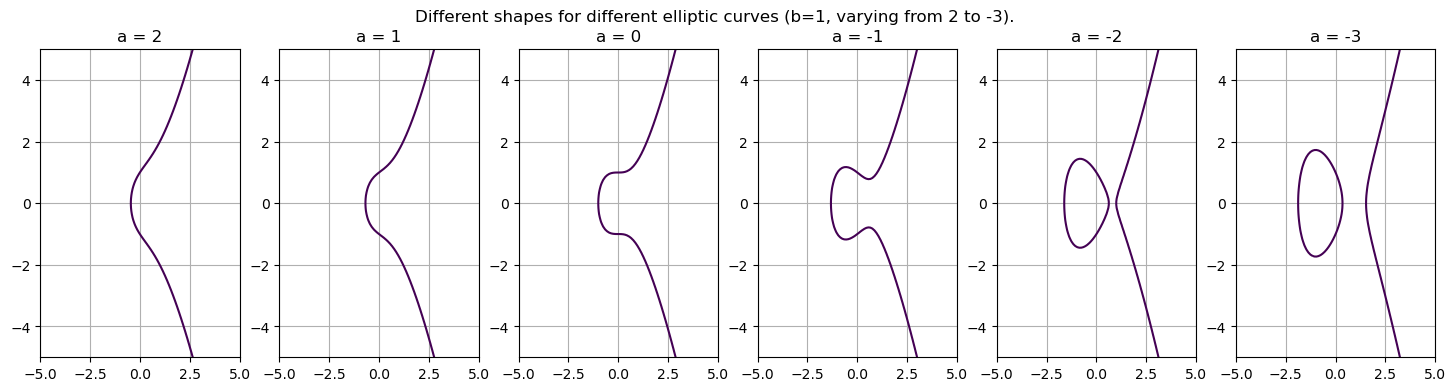

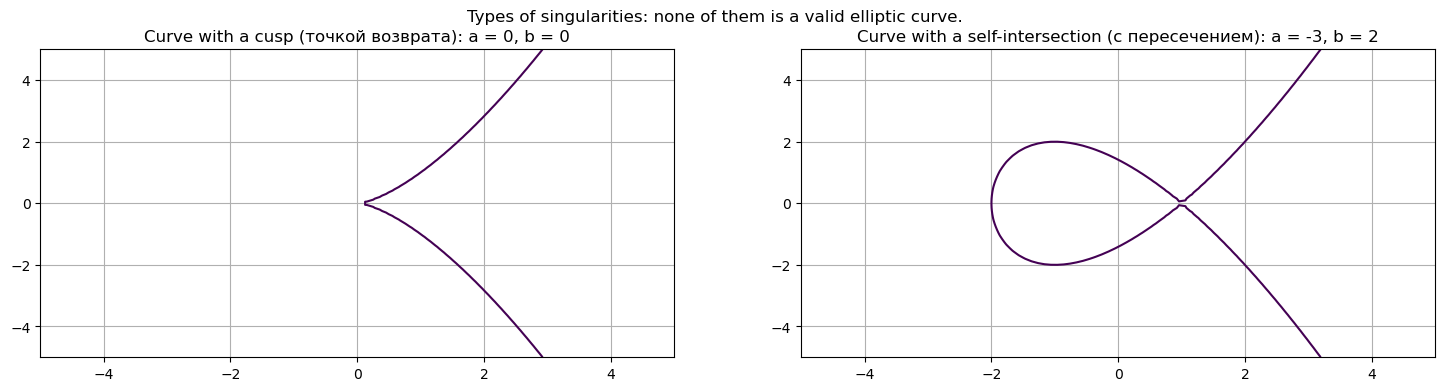

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

b = 1
a = 1
ax = [2, 1, 0, -1, -2, -3]
ncol = 1
nrow = len(ax)

figure, axis = plt.subplots(ncol, nrow, figsize=(18,4))
figure.suptitle('Different shapes for different elliptic curves (b=1, varying from 2 to -3).')
y, x = np.ogrid[-5:5:100j, -5:5:100j]
for i, a in enumerate(ax): 
    axis[i].contour(x.ravel(), y.ravel(), pow(y, 2) - pow(x, 3) - x * a - b, [0])
    axis[i].grid()
    axis[i].set_title(f"a = {a}")


figure, axis = plt.subplots(1, 2, figsize=(18,4))
figure.suptitle('Types of singularities: none of them is a valid elliptic curve.')
axis[0].contour(x.ravel(), y.ravel(), pow(y, 2) - pow(x, 3), [0])
axis[0].grid()
axis[0].set_title("Curve with a cusp (точкой возврата): a = 0, b = 0")
axis[1].contour(x.ravel(), y.ravel(), pow(y, 2) - pow(x, 3) - x * -3 - 2, [0])
axis[1].grid()
axis[1].set_title("Curve with a self-intersection (с пересечением): a = -3, b = 2")
plt.show()

For our aims, **we will also need a [point at infinity](https://en.wikipedia.org/wiki/Point_at_infinity)** (also known as ideal point) to be part of our curve. From now on, we will denote our point at infinity with the symbol 0 (zero).
<br/>If we want to explicitly take into account the point at infinity, we can refine our definition of elliptic curve as follows:
<br/>&emsp;&emsp;&emsp;<img src="https://habrastorage.org/getpro/habr/formulas/1e6/7ec/cff/1e67eccff3a5ea6f793053205e697214.svg"></tmg>

## Groups
A group in mathematics is a set for which we have defined a binary operation that we call "addition" and indicate with the symbol **+**. In order for the set  to be a group, addition must defined so that it respects the following four properties:

 * __closure (замыкание)__: if <img src="https://habrastorage.org/getpro/habr/formulas/372/e18/546/372e18546a3b7abb94c2672708bc5dfe.svg"></img> and <img src="https://habrastorage.org/getpro/habr/formulas/302/c72/04e/302c7204ea9987e698a70307646abd71.svg"></img> are members of 
 <img src="https://habrastorage.org/getpro/habr/formulas/cef/df6/91e/cefdf691e848b217adaec683ef3cd853.svg"></img>, then <img src="https://habrastorage.org/getpro/habr/formulas/6c5/11c/e07/6c511ce0713676e3c40aae76cb512104.svg"></img> is a member of 
 <img src="https://habrastorage.org/getpro/habr/formulas/cef/df6/91e/cefdf691e848b217adaec683ef3cd853.svg"></img>;
 * __associativity (ассоциативность)__: <img src="https://habrastorage.org/getpro/habr/formulas/c6d/d39/d21/c6dd39d214a2983216c01e781c076526.svg"></img>;
 * there exists an __identity element (единичный элемент)__ 0 such that <img src="https://habrastorage.org/getpro/habr/formulas/5ec/d76/ffe/5ecd76ffe38dd626ecb14caa0554ce9e.svg"></img>;
 * every element has an __inverse (обратная величина)__, that is: for every <img src="https://habrastorage.org/getpro/habr/formulas/372/e18/546/372e18546a3b7abb94c2672708bc5dfe.svg"></img> there exists 
  <img src="https://habrastorage.org/getpro/habr/formulas/302/c72/04e/302c7204ea9987e698a70307646abd71.svg"></img> such that <img src="https://habrastorage.org/getpro/habr/formulas/20c/8c7/ea3/20c8c7ea363e5eae30d25eeb049781cb.svg"></img>.

If we add a fifth requirement:
 * __commutativity (коммутативность)__: <img src="https://habrastorage.org/getpro/habr/formulas/3d4/c03/8f7/3d4c038f7d44fc44d2d45d381546d5ba.svg"></img>,
 
   then the group is called __abelian group (абелева группа)__.
   
Groups are nice because, if we can demonstrate that those four properties hold, we get some other properties for free. For example: __the identity element is unique__; also the __inverses are unique__, 
that is: for every <img src="https://habrastorage.org/getpro/habr/formulas/372/e18/546/372e18546a3b7abb94c2672708bc5dfe.svg"></img> 
there exists only one <img src="https://habrastorage.org/getpro/habr/formulas/302/c72/04e/302c7204ea9987e698a70307646abd71.svg"></img> such that 
<img src="https://habrastorage.org/getpro/habr/formulas/20c/8c7/ea3/20c8c7ea363e5eae30d25eeb049781cb.svg"></img> 
(and we can write <img src="https://habrastorage.org/getpro/habr/formulas/302/c72/04e/302c7204ea9987e698a70307646abd71.svg"></img> as <img src="https://habrastorage.org/getpro/habr/formulas/5df/bf1/e91/5dfbf1e910bbad1c74d49659165642ce.svg"></img>). 
Either directly or indirectly, these and other facts about groups will be very important for us later.

## The group law for elliptic curves. Algebraic addition.
We can define a group over elliptic curves. Specifically:
 * the elements of the group are the points of an elliptic curve;
 * the __identity element__ is the point at infinity 0;
 * the __inverse__ of a point __P__ is the one symmetric about the -axis;
 * __addition__ is given by the following rule: __given three aligned (лежащие на одной прямой), non-zero points P, Q and R, their sum is P + Q + R = 0__

So, Elliptic Curve is __subset of abelian group__ (P + Q + R = 0)

<img src="https://habrastorage.org/r/w1560/getpro/habr/post_images/94a/567/939/94a567939b88645be83086a53469cfc5.png"></img> The sum of three aligned point is 0.
<img src="https://habrastorage.org/r/w1560/getpro/habr/post_images/671/906/eab/671906eab17c7ac49a1651c06e081682.png"></img> -R is result of P + Q


 - **Samples for Python is here**: https://github.com/andreacorbellini/ecc/blob/master/scripts/ecdsa.py
 - **Samples for Javascript is here**: https://github.com/andreacorbellini/ecc/blob/master/interactive/ec.js
 - A primer on modular arithmetic, check out **[Khan Academy](https://www.khanacademy.org/computing/computer-science/cryptography/modarithmetic/a/what-is-modular-arithmetic)**

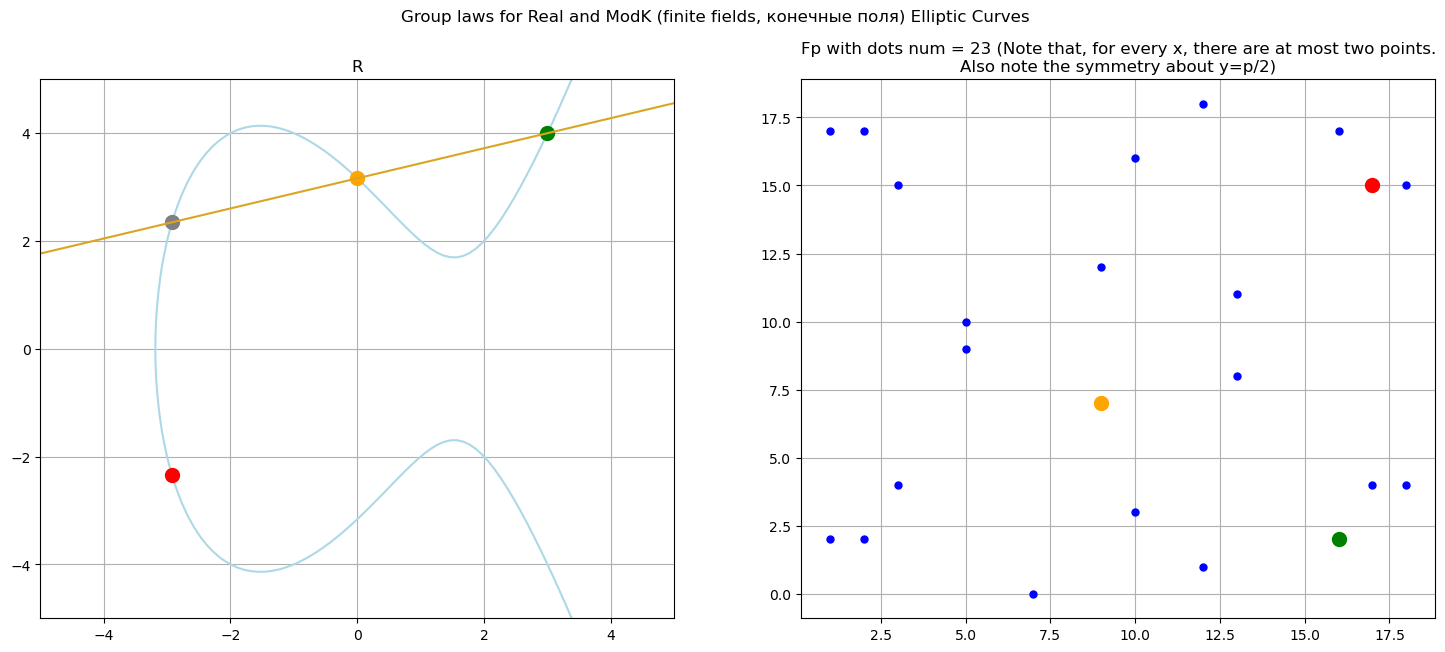

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import math
import collections

EllipticCurve = collections.namedtuple('EllipticCurve', 'b a')
CurvePoint = collections.namedtuple('CurvePoint', 'x y')

####### Elliptic Curve ###

curve = EllipticCurve(b=10, a=-7)


def get_y(x):
    # y^2 = x^3 + x*a + b
    return math.sqrt(pow(x, 3) + x * curve.a + curve.b)


def add_points(p1: CurvePoint, p2: CurvePoint) -> CurvePoint:
    # Returns the result of adding point p1 to point p2, according to the
    # group law for elliptic curves. The point at infinity is represented
    # as null.

    if p1 is None:
        return p2
    if p2 is None:
        return p1

    x1 = p1.x
    y1 = p1.y
    x2 = p2.x
    y2 = p2.y
    m = None

    if x1 != x2:
        # Two distinct points.
        m = ( y1 - y2 ) / ( x1 - x2 )
    else:
        if y1 == 0 and y2 == 0: 
            # This may only happen if p1 = p2 is a root of the elliptic
            # curve, hence the line is vertical.
            return None
        elif y1 == y2: 
            # The points are the same, but the line is not vertical.
            m = ( 3 * x1 * x1 + curve.a ) / y1 / 2
        else:
            # The points are the same and the line is vertical.
            return None

    x3 = m * m - x1 - x2
    y3 = m * ( x1 - x3 ) - y1

    return CurvePoint(x=x3, y=y3)

# P, Q, R, -R points
pointP = CurvePoint(x=0, y=get_y(0))
pointQ = CurvePoint(x=3, y=get_y(3))
pointAdd = add_points(pointP, pointQ)
pointR = CurvePoint(x=pointAdd.x, y=-pointAdd.y)


##########################

figure, axis = plt.subplots(1, 2, figsize=(18,7))
figure.suptitle('Group laws for Real and ModK (finite fields, конечные поля) Elliptic Curves')
min_xy = -5
max_xy = 5
y, x = np.ogrid[min_xy:max_xy:100j, min_xy:max_xy:100j]


######################### REALS ######################## 
axis[0].contour(x.ravel(), y.ravel(), pow(y, 2) - pow(x, 3) - x * curve.a - curve.b, [0], colors='lightblue')
axis[0].plot(pointP.x, pointP.y, 'o', color='orange', markersize=10, label='P')
axis[0].plot(pointQ.x, pointQ.y, 'o', color='green', markersize=10, label='Q')
axis[0].plot(pointR.x, pointR.y, 'o', color='grey', markersize=10, label='R')
axis[0].plot(pointAdd.x, pointAdd.y, 'o', color='red', markersize=10, label='ADD')
axis[0].axline((pointP.x, pointP.y), (pointQ.x, pointQ.y), color='goldenrod')
axis[0].grid()
axis[0].set_title("R")

######################### FINITE ########################

P = 19

def get_modk_points(k: int) -> list:
    # Returns a list of x,y points belonging to the curve from xMin to
    # xMax. The resulting array is ordered and may contain some null
    # points in case of discontinuities.

    points = [];
    
    for x in range(0, k, 1):
        for y in range(0, k, 1):
            factor = ( y * y - x * x * x - curve.a * x - curve.b ) % k
            if factor == 0:
                points.append(CurvePoint(x=x, y=y))
                
    return points;


def get_y_modk(x, points: list, k: int):
    
    for p in points:
        if p.x == x:
            y = p.y
            x = p.x
            factor = ( y * y - x * x * x - curve.a * x - curve.b ) % k
            if factor == 0:
                return y

    return None


def inverse_of_modk(n: int, k: int):
    n = +n % k
    
    if n < 0:
        n = n + k
        
    for m in range(0, k):
        factor = (n * m) % k
        if factor == 1:
            return m
        
    return None


def modk_add_points(p1: CurvePoint, p2: CurvePoint, k: int) -> CurvePoint:
    # Returns the result of adding point p1 to point p2, according to the
    # group law for elliptic curves. The point at infinity is represented
    # as null.

    if p1 is None: 
        return p2
    if p2 is None:
        return p1

    x1 = p1.x
    y1 = p1.y
    x2 = p2.x
    y2 = p2.y
    m = None

    if x1 != x2: 
        # Two distinct points.
        m = ( y1 - y2 ) * inverse_of_modk(x1 - x2, k)
    else:
        if y1 == 0 and y2 == 0:
            # This may only happen if p1 = p2 is a root of the elliptic
            # curve, hence the line is vertical.
            return None
        elif y1 == y2:
            # The points are the same, but the line is not vertical.
            m = ( 3 * x1 * x1 + curve.a ) * inverse_of_modk(2 * y1, k)
        else:
            # The points are not the same and the line is vertical.
            return None

    m %= k;

    x3 = ( m * m - x1 - x2 ) % k;
    y3 = ( m * ( x1 - x3 ) - y1 ) % k;

    if x3 < 0:
        x3 += k
    if y3 < 0:
        y3 += k

    return CurvePoint(x3, y3)


modkPoints = get_modk_points(P)
modk_xP = modkPoints[10].x
modk_xQ = modkPoints[18].x

# P, Q, R, -R points for Fp
modk_pointP = CurvePoint(x=modk_xP, y=get_y_modk(modk_xP, modkPoints, P))
modk_pointQ = CurvePoint(x=modk_xQ, y=get_y_modk(modk_xQ, modkPoints, P))
modk_pointAdd = modk_add_points(modk_pointP, modk_pointQ, P)

for p in modkPoints:
    axis[1].plot(p.x, p.y, 'o', color='blue', markersize=5)

axis[1].plot(modk_pointP.x, modk_pointP.y, 'o', color='orange', markersize=10, label='P')
axis[1].plot(modk_pointQ.x, modk_pointQ.y, 'o', color='green', markersize=10, label='Q')
axis[1].plot(modk_pointAdd.x, modk_pointAdd.y, 'o', color='red', markersize=10, label='ADD')
axis[1].grid()
axis[1].set_title(f"Fp with dots num = {len(modkPoints)} (Note that, for every x, there are at most two points.\nAlso note the symmetry about y=p/2)")
plt.show()



## <span style="color:red"> Key brick of elliptic curve cryptography.</span>
But there's a variant of the logarithm problem: the discrete logarithm problem. As we will see in the next post, if we reduce the domain of our elliptic curves, __scalar multiplication remains "easy", while the discrete logarithm becomes a "hard" problem__. This duality is the key brick of elliptic curve cryptography.

In [22]:
from IPython.display import HTML, IFrame

IFrame(src="interactive/reals-add.html", width=1200, height=900)

## Scalar multiplication and cyclic subgroups. 
As with reals, multiplication can be defined as: <img src="https://habrastorage.org/getpro/habr/formulas/71e/d4d/082/71ed4d082b4fd1c70f96bf52aa742e01.svg"></img>

Multiplication over points for elliptic curves in __Fp__ has an interesting property. Take the curve 
<img src="https://habrastorage.org/getpro/habr/formulas/394/273/053/394273053bbb9f74e39f7cf334678864.svg"></img> and the point __P(3, 6)__

In [25]:
curve = EllipticCurve(a=2, b=3)
p = 97

def modk_mul(p: CurvePoint, m: int, k: int) -> CurvePoint:
    if m == 0:
        return None
    accum = p
    for i in range(2, m+1):
        accum = modk_add_points(accum, p, k)
    return accum


def point2str(p: CurvePoint) -> str:
    if p is None:
        return '0'
    else:
        return f'({p.x}, {p.y})'
    
    
def get_point_order(p: CurvePoint, k: int, N: int) -> int:
    for m in range(1, N+1):
        mul = modk_mul(p, m, k)
        if mul is None:
            return m
    return None

P = CurvePoint(3, 6)
P0 = modk_mul(P, 0, p)
P1 = modk_mul(P, 1, p)
P2 = modk_mul(P, 2, p)
P3 = modk_mul(P, 3, p)
P4 = modk_mul(P, 4, p)
P5 = modk_mul(P, 5, p)
P6 = modk_mul(P, 6, p)
P7 = modk_mul(P, 7, p)
P8 = modk_mul(P, 8, p)
P9 = modk_mul(P, 9, p)
P10 = modk_mul(P, 10, p)
N = len(get_modk_points(p)) + 1 # null point is part of Fp

print(f'0*P = {point2str(P0)}')
print(f'1*P = {point2str(P1)}')
print(f'2*P = {point2str(P2)}')
print(f'3*P = {point2str(P3)}')
print(f'4*P = {point2str(P4)}')
print(f'5*P = {point2str(P5)}')
print(f'6*P = {point2str(P6)}')
print(f'7*P = {point2str(P7)}')
print(f'8*P = {point2str(P8)}')
print(f'9*P = {point2str(P9)}')
print(f'10*P = {point2str(P10)}')

print(f'\nCurve with a={curve.a}, b={curve.b} mod(p)={p} has:')
print(f'\t N = {N}')
orderP = get_point_order(P, p, N)
print(f'\t n (P order) = {orderP}')
h = N // orderP
print(f'\t h (subgroup cofactor) = {h}')

0*P = 0
1*P = (3, 6)
2*P = (80, 10)
3*P = (80, 87)
4*P = (3, 91)
5*P = 0
6*P = (3, 6)
7*P = (80, 10)
8*P = (80, 87)
9*P = (3, 91)
10*P = 0

Curve with a=2, b=3 mod(p)=97 has:
	 N = 100
	 n (P order) = 5
	 h (subgroup cofactor) = 20


## Signing with ECDSA
The scenario is the following: __Alice wants to sign a message with her private key (dA), and Bob wants to validate the signature using Alice's public key (Ha)__. Nobody but Alice should be able to produce valid signatures. Everyone should be able to check signatures.

Again, Alice and Bob are using the same domain parameters. The algorithm we are going to see is ECDSA, a variant of the [Digital Signature Algorithm](https://en.wikipedia.org/wiki/Digital_Signature_Algorithm) applied to elliptic curves.

In [65]:
import os
import sys
sys.path.append(os.path.abspath("/opt/conda/notebooks/Education/scripts"))
from ecdsa import EllipticCurve as FpEllipticCurve

demo_curve = FpEllipticCurve(
    name='demo',
    p=97,
    a=2,
    b=3,
    g=(3, 6),
    n=5,
    h=20
)

assert demo_curve.is_on_curve(point=(3, 6))

sk, pk = demo_curve.make_keypair()

print(f'SigKey: {sk}\t PubKey: {pk}')
msg = b'Hello!'
r, s, k = demo_curve.sign_message(sk, msg)
signature = (r, s)
print(f'Message: {msg}')
print(f'Signature: (r, s) = {signature}')
print(f'Priv sign key: (k) = {k}')
veryfy = demo_curve.verify_signature(pk, msg, signature)
print(f'Verify: = {veryfy}')

print('\nAttack SigKey for predictable k')
msg1, msg2 = b'Msg1', b'Msg2'
signatures = []
zs = []
for msg in [msg1, msg2]:
    z = demo_curve.hash_message(msg)
    zs.append(z)
    x, y = demo_curve.scalar_mult(k, demo_curve.g)
    r = x % demo_curve.n
    s = ((z + r * sk) * demo_curve.inverse_mod(k, demo_curve.n)) % demo_curve.n
    signature = (r, s)
    print(f'Msg: {msg}, k: {k}, signature (r, s): {signature}')
    signatures.append(signature)
    
r1, s1 = signatures[0]
r2, s2 = signatures[1]
assert r1 == r2, 'r should be equal for the same k'
z1, z2 = zs[0], zs[1]
restored_k = (z1 - z2) * demo_curve.inverse_mod(s1 - s2, demo_curve.n) % demo_curve.n
print(f'Restored k: {restored_k}')
r, s, z = r2, s2, z2
restored_sk = (s*restored_k - z) * demo_curve.inverse_mod(r, demo_curve.n) % demo_curve.n
print(f'Restored SigKey: {restored_sk}')

SigKey: 4	 PubKey: (3, 91)
Message: b'Hello!'
Signature: (r, s) = (3, 4)
Priv sign key: (k) = 1
Verify: = signature matches

Attack SigKey for predictable k
Msg: b'Msg1', k: 1, signature (r, s): (3, 4)
Msg: b'Msg2', k: 1, signature (r, s): (3, 3)
Restored k: 1
Restored SigKey: 4


## Encryption with ECDH
ECDH is a variant of the [Diffie-Hellman algorithm](https://en.wikipedia.org/wiki/Diffie%E2%80%93Hellman_key_exchange) for elliptic curves. It is actually a [key-agreement protocol](https://en.wikipedia.org/wiki/Key-agreement_protocol), more than an encryption algorithm. This basically means that ECDH defines (to some extent) how keys should be generated and exchanged between parties. How to actually encrypt data using such keys is up to us.

In [82]:
import os
import sys
sys.path.append(os.path.abspath("/opt/conda/notebooks/Education/scripts"))
from ecdsa import EllipticCurve as FpEllipticCurve

demo_curve = FpEllipticCurve(
    name='demo',
    p=97,
    a=2,
    b=3,
    g=(3, 6),
    n=5,
    h=20
)

assert demo_curve.is_on_curve(point=(3, 6))

alice_sk, alice_pk = demo_curve.make_keypair()
while True:
    bob_sk, bob_pk = demo_curve.make_keypair()
    if bob_sk != alice_sk:
        break
print(f'Alice SigKey: {alice_sk}\t Alice PubKey: {alice_pk}')
print(f'Bob SigKey: {bob_sk}\t Bob PubKey: {bob_pk}')

s1 = demo_curve.scalar_mult(alice_sk, bob_pk)
s2 = demo_curve.scalar_mult(bob_sk, alice_pk)
print(f'SK Alice side: {s1}')
print(f'SK Bob side: {s2}')


Alice SigKey: 3	 Alice PubKey: (80, 87)
Bob SigKey: 4	 Bob PubKey: (3, 91)
SK Alice side: (80, 10)
SK Bob side: (80, 10)
